# Assignment 1: Data Curation
### Data 512
### Sunday, September 29
### Tara Wilson

This Jupyter Notebook is created using [Python version 3.7](https://www.python.org/downloads/release/python-370/).

### Data Acquisiton

First, we will import the necessary libraries to run the code. The following libraries are used:

[json](https://docs.python.org/3/library/json.html)  
[requests](https://realpython.com/python-requests/)  
[pandas](https://pandas.pydata.org/)    
[numpy](https://numpy.org/)  
[matplotlib.pyplot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html)  
[matplotlib.ticker](https://matplotlib.org/3.1.0/api/ticker_api.html)

In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

We will create a method called `make_and_save_api_call` that takes in the following as parameters:
    * endpoint - the url for the wikimedia query
    * params - the query parameters and corresponding values as a dictionary
    * filename - the name of the file, with a .json extension, to save the results to
    
The function then makes the call to the api with the necessary parameters and saves the returned json object to a file in the current working directory.

Code is adapted from 

In [2]:
def make_and_save_api_call(endpoint, params, filename):
    call = requests.get(endpoint.format(**params))
    response = call.json()
    with open(filename, "w", encoding="utf-8") as file:
        json.dump(response, file)

We then will call this method to make the 5 api calls outlined below:

In [3]:
# pageview counts for a project, desktop access
pageview_desktop_endpoint = "https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}"

pageview_desktop_params = {"project": "en.wikipedia.org",
                           "access": "desktop",
                            "agent": "user",
                            "granularity": "monthly",
                            "start": "2015070100",
                            "end": "2019083000"
                           }

make_and_save_api_call(pageview_desktop_endpoint, pageview_desktop_params, "pageviews_desktop_201507-201908.json")

In [4]:
# pageview counts for a project, mobile app access
pageview_mobile_app_endpoint = "https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}"

pageview_mobile_app_params = {"project": "en.wikipedia.org",
                           "access": "mobile-app",
                            "agent": "user",
                            "granularity": "monthly",
                            "start": "2015070100",
                            "end": "2019083000"
                           }

make_and_save_api_call(pageview_mobile_app_endpoint, pageview_mobile_app_params, "pageviews_mobile-app_201507-201908.json")

In [5]:
# pageview counts for a project, mobile web access
pageview_mobile_web_endpoint = "https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}"

pageview_mobile_web_params = {"project": "en.wikipedia.org",
                           "access": "mobile-web",
                            "agent": "user",
                            "granularity": "monthly",
                            "start": "2015070100",
                            "end": "2019083000"
                           }

make_and_save_api_call(pageview_mobile_web_endpoint, pageview_mobile_web_params, "pageviews_mobile-web_201507-201908.json")

In [6]:
# legacy pageview data, mobile access
legacy_pagecount_mobile_endpoint = "https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}"

legacy_pagecount_mobile_params = {"project": "en.wikipedia.org",
                           "access-site": "mobile-site",
                            "granularity": "monthly",
                            "start": "2007120100",
                            "end": "2016073100"
                           }

make_and_save_api_call(legacy_pagecount_mobile_endpoint, legacy_pagecount_mobile_params, "pagecounts_mobile-site_200712-201607.json")

In [7]:
# legacy pageview data, desktop access
legacy_pageview_desktop_endpoint = "https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}"

legacy_pageview_desktop_params = {"project": "en.wikipedia.org",
                           "access-site": "desktop-site",
                            "granularity": "monthly",
                            "start": "2007120100",
                            "end": "2016073100"
                           }

make_and_save_api_call(legacy_pageview_desktop_endpoint, legacy_pageview_desktop_params, "pagecounts_desktop-site_200712-201607.json")

### Data processing

Now we can process the json files we created in the above section. The json object for each month has the following information:

    Pagecount API:
       * project
       * access-site
       * granularity
       * timestamp
       * count
       
    Pageviews API:
       * project
       * access
       * agent
       * granularity
       * timestamp
       * views
       
Since the details of project and granularity are the same for all months, we need to only save the type of access, the timestamp and the number of views.

We will start by combining the Pageviews API responses for mobile-app and mobile-web into one mobile term. To do so, we pull out the timestamp and count value for each json object and save these to a pandas dataframe.

In [8]:
pageviews_mobile_app = pd.read_json("pageviews_mobile-app_201507-201908.json")["items"]

pageviews_mobile_app_df = pd.DataFrame({})
timestamp = []
count = []
for row in pageviews_mobile_app:
    timestamp.append(row["timestamp"])
    count.append(row["views"])
    
pageviews_mobile_app_df["timestamp"] = timestamp
pageviews_mobile_app_df["pageview_mobile_views"] = count

In [9]:
pageviews_mobile_web = pd.read_json("pageviews_mobile-web_201507-201908.json")["items"]

pageviews_mobile_web_df = pd.DataFrame({})
timestamp = []
count = []
for row in pageviews_mobile_web:
    timestamp.append(row["timestamp"])
    count.append(row["views"])
    
pageviews_mobile_web_df["timestamp"] = timestamp
pageviews_mobile_web_df["pageview_mobile_views"] = count

We then set the dataframe index to be timestamp for both the mobile-app and mobile-web dataframes. This allows us to add the dataframes, where each number of counts is summed for each month. We now have a count for all mobile pageviews aggregated monthly.

In [10]:
pageviews_mobile_web_df = pageviews_mobile_web_df.set_index(["timestamp"])
pageviews_mobile_app_df = pageviews_mobile_app_df.set_index(["timestamp"])

pageviews_mobile = pageviews_mobile_web_df + pageviews_mobile_app_df

We will now repeat the json to dataframe conversion for the remaining 3 json files to end up with additional dataframes for pageviews on desktop, pagecounts on desktop, and pagecounts on mobile and set the timestamp to be the index.

In [11]:
pageviews_desktop = pd.read_json("pageviews_desktop_201507-201908.json")["items"]

pageviews_desktop_df = pd.DataFrame({})
timestamp = []
count = []
for row in pageviews_desktop:
    timestamp.append(row["timestamp"])
    count.append(row["views"])
    
pageviews_desktop_df["timestamp"] = timestamp
pageviews_desktop_df["pageview_desktop_views"] = count

pageviews_desktop_df = pageviews_desktop_df.set_index(["timestamp"])

In [12]:
pagecounts_desktop = pd.read_json("pagecounts_desktop-site_200801-201607.json")["items"]

pagecounts_desktop_df = pd.DataFrame({})
timestamp = []
count = []
for row in pagecounts_desktop:
    timestamp.append(row["timestamp"])
    count.append(row["count"])
    
pagecounts_desktop_df["timestamp"] = timestamp
pagecounts_desktop_df["pagecount_desktop_views"] = count

pagecounts_desktop_df = pagecounts_desktop_df.set_index(["timestamp"])

In [13]:
pagecounts_mobile = pd.read_json("pagecounts_mobile-site_200801-201607.json")["items"]

pagecounts_mobile_df = pd.DataFrame({})
timestamp = []
count = []
for row in pagecounts_mobile:
    timestamp.append(row["timestamp"])
    count.append(row["count"])
    
pagecounts_mobile_df["timestamp"] = timestamp
pagecounts_mobile_df["pagecount_mobile_views"] = count

pagecounts_mobile_df = pagecounts_mobile_df.set_index(["timestamp"])

Since all 4 dataframes have an index of the `timestamp` column, we can join them together. Read more about pandas joins [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html).

We then replace all missing data, where there is not available data from that API for a certain month, with 0.

Next, we aggregate all pagecount data and all pageview data to create two additional columns of these respective totals. Finally, we can parse the `timestamp` column to pull out the year (first 4 characters) and the month (next 2 characters) into their own respective columns as well. 

In [14]:
all_data = pageviews_mobile.join(pageviews_desktop_df).join(pagecounts_desktop_df, how="outer").join(pagecounts_mobile_df, how="outer")

all_data[np.isnan(all_data)] = 0

all_data["pagecount_all_views"] = all_data["pagecount_desktop_views"] + all_data["pagecount_mobile_views"] 
all_data["pageview_all_views"] = all_data["pageview_desktop_views"] + all_data["pageview_mobile_views"] 
all_data = all_data.reset_index()
all_data["year"] = all_data["timestamp"].str[0:4]
all_data["timestamp2"] = all_data["timestamp"]
all_data["month"] = all_data["timestamp2"].str[4:6]

We then write the resulting dataset to a csv format and save it to the current working directory. The final columns are:
    * year (YYYY)
    * month (MM)
    * pagecount_all_views (pagecount_desktop_views + pagecount_mobile_views)
    * pagecount_desktop_views (num_views)
    * pagecount_mobile_views (num_views)
    * pageview_all_views (pageview_desktop_views + pageview_mobile_views)
    * pageview_desktop_views (num_views)
    * pageview_mobile_views (num_views)

In [15]:
all_data.to_csv("en-wikipedia_traffic_200712-201809.csv", sep=",", 
                columns=["year", "month", "pagecount_all_views", "pagecount_desktop_views", "pagecount_mobile_views", "pageview_all_views", "pageview_desktop_views", "pageview_mobile_views"])

### Analysis

We can then visualize the site traffice data.

First, we can program methods to format the tick labels properly. The `y_fmt` function adds a suffix to the number to make the axis labels more legible. The `x_fmt` function makes it so only the first label for each year shows up on the plot so the x axis is not cluttered with labels for each month as viewers can infer this easily enough.

Both x and y formatter functions are adopted from code found [here](https://stackoverflow.com/questions/40566413/matplotlib-pyplot-auto-adjust-unit-of-y-axis).

In [16]:
def y_fmt(tick_val, pos):
    if tick_val > 1000000000:
        val = int(tick_val) / 1000000000
        return "{:.0f} Billion".format(val)
    elif tick_val > 1000000:
        val = int(tick_val) / 1000000
        return "{:.0f} Million".format(val)
    elif tick_val > 1000:
        val = int(tick_val) / 1000
        return "{:.0f} Thousand".format(val)
    else:
        return tick_val

In [17]:
def x_fmt(tick_val, pos):
    if tick_val % 12 == 0:
        return all_data["year"][tick_val]
    else:
        return ""

Finally, we plot the data. Using the matplotlib library linked above, we plot different lines for each category, display the resulting graphic and store it to a .png in the current working directory as well.

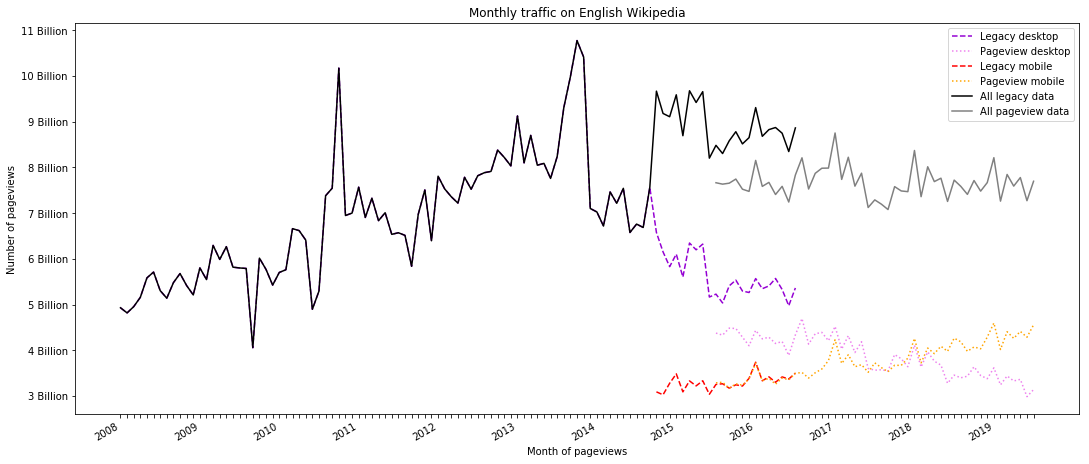

In [18]:
all_data.replace(0, np.nan, inplace=True)

fig = plt.figure(1, figsize=(18,8))
ax = fig.add_subplot(1, 1, 1)

plt.title("Monthly traffic on English Wikipedia")
ax.set_ylabel("Number of pageviews")
ax.set_xlabel("Month of pageviews")

plt.plot(all_data["timestamp"], all_data["pagecount_desktop_views"], "--", color="darkviolet", label = "Legacy desktop")
plt.plot(all_data["timestamp"], all_data["pageview_desktop_views"], ":", color="violet", label = "Pageview desktop")
plt.plot(all_data["timestamp"], all_data["pagecount_mobile_views"], "--", color="red", label = "Legacy mobile")
plt.plot(all_data["timestamp"], all_data["pageview_mobile_views"], ":", color="orange", label = "Pageview mobile")

plt.plot(all_data["timestamp"], all_data["pagecount_all_views"], color="black", label = "All legacy data")
plt.plot(all_data["timestamp"], all_data["pageview_all_views"], color="grey", label = "All pageview data")

plt.legend()
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))

fig.autofmt_xdate()

plt.savefig("en-wikipedia_traffic_200712-201809.png")
plt.show()

You can clearly see that from 2008 - 2013, the viewcount rose steadily. We see a huge usage peak at the beginning of 2014, followed by a dropoff and then a leveling out around 8 Billion total page visits per day. Another piece to note is that right around the beginning of 2018 we see a switch from the number of desktop views outweighing the number of mobile views to mobile views surpassing desktop views. 

The switch from the legacy pagecount api to the pageview api came with an option to only query user data and ignore all page hits from crawlers. This likely explains the drop off in all aggregated data around the middle of 2015. 

Mobile data was not available until October of 2014, explaining the fact that legacy desktop data and all legacy data follow the same trend until this point in time.